# Bridges Crumbling down!

## **Executive Summary**: 

The goal of this project is to try and understand what factors lead up to a depreciated state. We are defining a depreciated state as the state where a bridge is in need of repairs, and should be closed down. Due to need, a bridge may be depreciated, but still in use. We processed the data from the states of Pennsylvania and Massachusetts provided by their respective Departments of Transportation to see if we could determine what factors contributed the most in the depreciation effect. We utilize dynamic modelling methods to analyze Pennsylvania's more robust features and then pare down the features so that we can make comparisons to Massachusetts less robust data set. During our comparison, despite having the exact same features we received a different score for both state this is exciting as undocumented factors may be contributing to the divergence, and it is worth further examination.

## **Data Cleaning**: 
For our cleaning process, we examined both sets of data and then based off the table information guide provided by PENNDOT I converted both systems to a similar scale. For my PA exclusive model, I kept more features that I believe may have an influence on the depreciation of a bridge such as city code and average daily traffic. My score noticeably went up for PA in the MA/PA comparison model versus my original split PA model which means that my second model is more than likely underfitting and by removing features I am removing features which can be enlightening towards depreciation.

## **Success Criteria**: 
I wanted to see if I could narrow down the predictors to determine whether or not a bridge which would become deficient and if there would be a substantial difference between states. I was actually hoping for a larger discrepancy, and then attempt to see why. We were able to determine influential factors, and see discrepancy depending on size so for now I'll deem it a success!
For my model selection, I went with random forests. For the amount of features I wanted to incorporate this seemed like the best choice for incorporating all of them.

## **Current Results**: 
Greatest surprise so far is that my geographical component has the largest influence on my model, followed by city code and average daily traffic. The 3rd and 4th category make quite a bit of sense to me as city budgets can determine which bridges/infrastructure gets focused on in a given year and may be ignored for a period of time. High daily traffic can also influence which bridges are more likely to fall faster. Latitude and longitude are interesting in that I didn't believe they would have as high of an influence as they ended up having, especially that it would carry over into massachusetts as well. More research necessary to determine actual effects.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing, ensemble
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
% matplotlib inline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
rf = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc
from sklearn.cross_validation import cross_val_score, StratifiedKFold

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dfpa2 = pd.read_csv('/Users/Red/Desktop/GA/Cap/Pennsylvania_Bridges.csv')
dfm = pd.read_csv('/Users/Red/Desktop/GA/Cap/BridgesMass.csv')

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,10,19,33,34,35,42,82,85,96,115,134,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def eda_helper(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # The null count for a column. Columns with no nulls are generally more interesting
        dict_.update({"null_count" : data.isnull().sum()})
        # Counting the unique values in a column
        # This is useful for seeing how interesting the column might be as a feature
        dict_.update({"unique_count" : len(data.unique())})
        # Finding the types of data in the column
        # This is useful for finding out potential problems with a column having strings and ints
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        #dict_.update({"score" : match[1]})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
    #eda_df = eda_df.sort_values(['null_count','unique_count'], ascending=[True, False])
    return eda_df

Here are our base data years, I chose to graph these prior to modifying the dataset to examine outliers within the years. The first thing that I see are the 0 years which we need to eliminate from our data, and the outlier years for MA and PA which are 1850 and 1930 respectively. After analyzing the depreciation rate for the older bridges, I decided to exclude them from my dataset as new materials and techniques have skewed predictions later on.

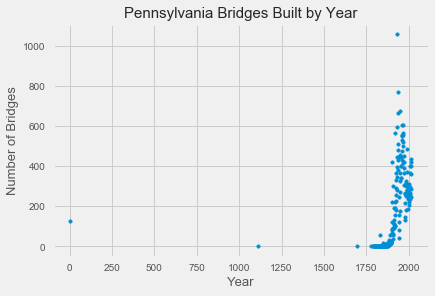

In [88]:
pa_total_year = dfpa2.YEARBUILT.value_counts().sort_index()

plt.scatter(pa_total_year.index, pa_total_year, s=12)
plt.yscale('linear')
plt.title('Pennsylvania Bridges Built by Year', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Bridges', fontsize=13)
plt.show()

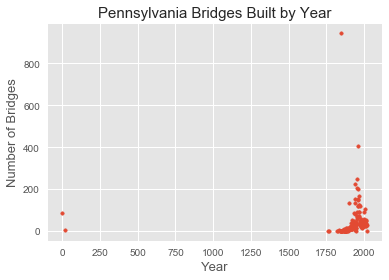

In [5]:
ma_year = dfm.Year_Built.value_counts().sort_index()

plt.scatter(ma_year.index, ma_year, s=12)
plt.yscale('linear')
plt.title('Pennsylvania Bridges Built by Year', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Bridges', fontsize=13)
plt.show()

I chose the following columns from the PA dataset as they were the most pertinent and most complete features available from the set. Certain features such as federal funding unfortunately had a low confirmation rate, and thus were cut.   

References:                                              
X = Latitude                                      
Y = Longitude                                               
CTY_CODE = City Code                                              
ADTTOTAL = Average Daily Traffic Total                                              
BRIDGE_ID kept only for tableau visualizations                                              
COVERED_BRIDGE = whether a bridge is covered or not                                              
CUSTODIAN = Who is in charge of maintaining the bridge                                               
DECK_AREA = Bridge deck area                                               
DECKWIDTH = width of the deck                                               
DEPT_MAIN_MATERIAL_TYPE = Main material for the span                                               
DEPT_MAIN_PHYSICAL_TYPE = Physical make-up of the main span of the structure                                         
DESIGNMAIN = Design of bridge                                               
HISTSIGN = Whether it is historically significant                                               
LENGTH = length of bridge                                               
MATERIALMAIN = main material of bridge                                               
NBI_RATING = Indicates if the bridge is structurally deficient or functionally obsolete, based on the values found in condition rating and/or appraisal rating fields                                               
STATE_LOCAL = jurisdiction of bridge                                               
STRRATING = Structural evaluation rating                                               
YEARBUILT = year it was built                                               
YEARRECON = year it was reconstructed                                               
FLOOD_INSP = indicator bridges that need to be inspected after floods                                               
KIND_HWY = route signing prefix                                              

In [6]:
dfpa_ = dfpa2[['X','Y','CTY_CODE','ADTTOTAL','BRIDGE_ID','COVERED_BRIDGE','CUSTODIAN','DECK_AREA','DECKWIDTH', 'DEPT_MAIN_MATERIAL_TYPE'
               , 'DEPT_MAIN_PHYSICAL_TYPE', 'DESIGNMAIN', 'HISTSIGN', 'LENGTH', 'MATERIALMAIN', 
               'NBI_RATING', 'STATE_LOCAL', 'STRRATING', 'YEARBUILT', 'YEARRECON', 'FLOOD_INSP', 'KIND_HWY']] 

In [7]:
eda_helper(dfpa_)

,data_type,null_count,unique_count
X,{float64},0,38205
Y,{float64},0,37761
CTY_CODE,{int64},0,67
ADTTOTAL,{float64},1194,9116
BRIDGE_ID,"{int, str}",0,38480
COVERED_BRIDGE,{float64},1412,3
CUSTODIAN,"{float, str}",52,32
DECK_AREA,{float64},0,14590
DECKWIDTH,{float64},610,1096
DEPT_MAIN_MATERIAL_TYPE,{float64},6,10


In [7]:
dfpa_ = dfpa_.dropna()

A large amount of the data presented was in a var

In [9]:
dfpa_.NBI_RATING.value_counts()

0.0    17895
1.0     5327
2.0     4103
Name: NBI_RATING, dtype: int64

In [8]:
dfpa_['HISTSIGN'] = dfpa_['HISTSIGN'].replace({'!':0, '5':0, '4':0, '3':0, '2':1})
dfpa_['CUSTODIAN'] = dfpa_['CUSTODIAN'].replace({'XX':0})
dfpa_['STATE_LOCAL'] = dfpa_['STATE_LOCAL'].replace({'S':1,'L':0})

In [9]:
dfpa_['NBI_RATING'] = dfpa_['NBI_RATING'].replace({2:1})

In [10]:
dfpa_=dfpa_[dfpa_.STRRATING != 'N']
dfpa_=dfpa_[dfpa_.KIND_HWY != 'N']
dfpa_=dfpa_[dfpa_.KIND_HWY !='!']

In [11]:
dfpa_.HISTSIGN = dfpa_.HISTSIGN.astype(float)
dfpa_.CUSTODIAN = dfpa_.CUSTODIAN.astype(float)
dfpa_.STRRATING = dfpa_.STRRATING.astype(float)
dfpa_.KIND_HWY = dfpa_.KIND_HWY.astype(float)

While not entirely relevant to bridge depreciation, I wanted to see how the model would do in regards to predicting historical significance as well.

In [47]:
X = dfpa_.drop(['HISTSIGN', 'BRIDGE_ID'], axis = 1)
y = dfpa_.HISTSIGN

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 8)

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17928, 20), (4482, 20), (17928,), (4482,))

Feature ranking:
1. feature X (0.099411)
2. feature Y (0.098565)
3. feature CTY_CODE (0.090085)
4. feature ADTTOTAL (0.081189)
5. feature COVERED_BRIDGE (0.077134)
6. feature CUSTODIAN (0.074063)
7. feature DECK_AREA (0.073363)
8. feature DECKWIDTH (0.068235)
9. feature DEPT_MAIN_MATERIAL_TYPE (0.059455)
10. feature DEPT_MAIN_PHYSICAL_TYPE (0.045441)
11. feature DESIGNMAIN (0.037887)
12. feature LENGTH (0.037645)
13. feature MATERIALMAIN (0.034610)
14. feature NBI_RATING (0.030636)
15. feature STATE_LOCAL (0.027774)
16. feature STRRATING (0.026255)
17. feature YEARBUILT (0.013244)
18. feature YEARRECON (0.012245)
19. feature FLOOD_INSP (0.009325)
20. feature KIND_HWY (0.003438)


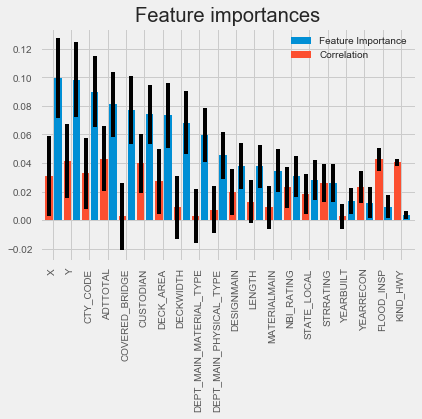

In [50]:
from sklearn.ensemble import ExtraTreesClassifier
plt.style.use('fivethirtyeight')

def feature_importance_eda(X, y):
    
    '''Get an estimate of the feature importance of data'''
    
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    
    #For correlation comparison
    data = pd.concat([X, y], axis=1)
    d = abs(data.corr().iloc[:,-1][:-1])
    
    features = []
    columns = []
    for f, col in enumerate(X.columns):
        print("%d. feature %s (%f)" % (f + 1, col, importances[indices[f]]))
        feature = [col, importances[indices[f]], d[col]]
        features.append(feature)
        columns.append(col)
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar([(x+0.5)*2 for x in range(X.shape[1])], importances[indices],
            yerr=std[indices], label='Feature Importance')
    
    plt.bar([(x* 2) for x in range(X.shape[1])], d[indices],
            yerr=std[indices], label='Correlation')
    plt.rcParams.update({'font.size': 20})
    plt.xticks([(x*2)+0.4 for x in range(X.shape[1])], columns, rotation='vertical')
    plt.xlim([-1, (2 * X.shape[1])])
    plt.legend()
    plt.show()
    return pd.DataFrame(features, columns=['Feature', 'Importance', 'Correlation'])


#Run function
feature_importance = feature_importance_eda(X, y)

In [51]:
def evaluate_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) #accuracy score of model
    con = confusion_matrix(y_test, y_pred) #make a confusion matrix
    crep = classification_report(y_test, y_pred)  #create classifcation report
    
    print con
    print crep
    
    return acc

In [19]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(X,y)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 2, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': 'balanced'}
0.96231274467
[[5085  261]
 [  13   71]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97      5346
        1.0       0.21      0.85      0.34        84

avg / total       0.99      0.95      0.96      5430

0.949539594843
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [89]:
X = dfpa_.drop(['NBI_RATING', 'BRIDGE_ID'], axis = 1)
y = dfpa_.NBI_RATING

Feature ranking:
1. feature X (0.318120)
2. feature Y (0.070863)
3. feature CTY_CODE (0.068589)
4. feature ADTTOTAL (0.061052)
5. feature COVERED_BRIDGE (0.058728)
6. feature CUSTODIAN (0.058506)
7. feature DECK_AREA (0.054743)
8. feature DECKWIDTH (0.049141)
9. feature DEPT_MAIN_MATERIAL_TYPE (0.048544)
10. feature DEPT_MAIN_PHYSICAL_TYPE (0.039789)
11. feature DESIGNMAIN (0.031113)
12. feature HISTSIGN (0.030146)
13. feature LENGTH (0.026468)
14. feature MATERIALMAIN (0.018987)
15. feature STATE_LOCAL (0.018120)
16. feature STRRATING (0.014641)
17. feature YEARBUILT (0.012231)
18. feature YEARRECON (0.010621)
19. feature FLOOD_INSP (0.006890)
20. feature KIND_HWY (0.002707)


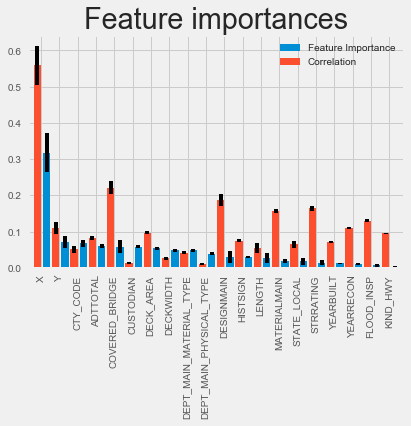

In [21]:
feature_importance = feature_importance_eda(X,y)

For each model in this notebook, I'll have my original score and then a roc_auc score following it

In [91]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(X,y)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 2, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 5, 'class_weight': None}
0.906081460372
[[2804  345]
 [ 363  970]]
             precision    recall  f1-score   support

        0.0       0.89      0.89      0.89      3149
        1.0       0.74      0.73      0.73      1333

avg / total       0.84      0.84      0.84      4482

0.84203480589
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [23]:
#dfpa_.to_csv('PAadjusted.csv')

In [13]:
dfpa_ = dfpa_[(dfpa_.YEARBUILT >= 1930) & (dfpa_.YEARBUILT <= 2010)]

In [25]:
#dfpa_.to_csv('PAadjusted1930.csv')

As previously stated in the appendix NBI_RATING is the depreciation score as measured by the state of Pennsylvania and will be my y value for all remaining pennsylvania models

Feature ranking:
1. feature X (0.299668)
2. feature Y (0.087700)
3. feature CTY_CODE (0.066698)
4. feature ADTTOTAL (0.065302)
5. feature COVERED_BRIDGE (0.064854)
6. feature CUSTODIAN (0.059050)
7. feature DECK_AREA (0.053992)
8. feature DECKWIDTH (0.053658)
9. feature DEPT_MAIN_MATERIAL_TYPE (0.049266)
10. feature DEPT_MAIN_PHYSICAL_TYPE (0.044239)
11. feature DESIGNMAIN (0.031178)
12. feature HISTSIGN (0.030858)
13. feature LENGTH (0.019919)
14. feature MATERIALMAIN (0.018392)
15. feature STATE_LOCAL (0.017468)
16. feature STRRATING (0.014425)
17. feature YEARBUILT (0.011717)
18. feature YEARRECON (0.009862)
19. feature FLOOD_INSP (0.001411)
20. feature KIND_HWY (0.000344)


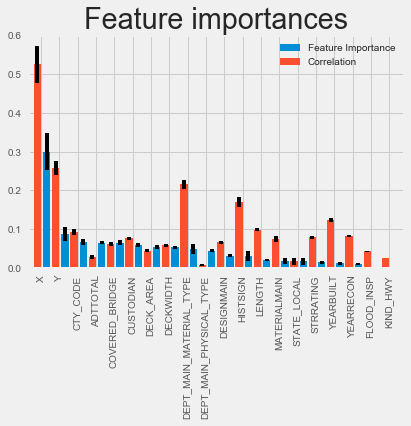

In [26]:
X = dfpa_.drop(['NBI_RATING', 'BRIDGE_ID'], axis = 1)
y = dfpa_.NBI_RATING
feature_importance = feature_importance_eda(X,y)

In [27]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(X_test,y_test)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 5, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 5, 'class_weight': 'balanced'}
0.959378870485
[[5094  252]
 [  13   71]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97      5346
        1.0       0.22      0.85      0.35        84

avg / total       0.99      0.95      0.96      5430

0.951197053407
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [28]:
def retest(model):
    rtsc = cross_val_score(model, X, y, cv=StratifiedKFold(y, shuffle=True),n_jobs=-1)
    sc = rtsc.std()
    m = rtsc.mean()
    return m, sc

Retest the model and see how it compares to my previous measurement

In [29]:
retest(rf)

(0.88933516471546392, 0.00049437885569331619)

In [30]:
xgb = XGBClassifier()
xgb.fit(X_test,y_test)
preds = xgb.predict_proba(X_test)[:,1]
preds

array([ 0.00038268,  0.00044028,  0.0001409 , ...,  0.00021499,
        0.00022713,  0.00066283], dtype=float32)

I created two more charts to depict the amount of bridges created per year for the two different states

In [17]:
rec = dfpa_[(dfpa_.YEARRECON > 0)]

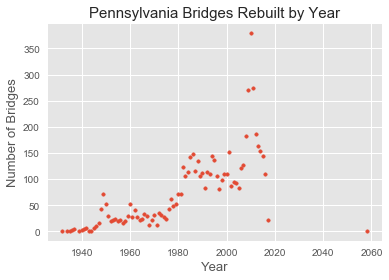

In [23]:
pa_year = rec.YEARRECON.value_counts().sort_index()

plt.scatter(pa_year.index, pa_year, s=12)
plt.yscale('linear')
plt.title('Pennsylvania Bridges Rebuilt by Year', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Bridges', fontsize=13)
plt.show()

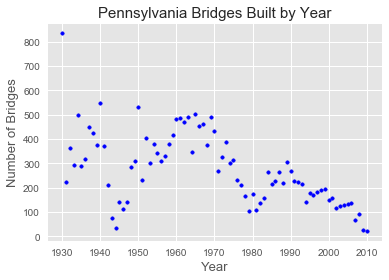

In [34]:
pa_year = dfpa_.YEARBUILT.value_counts().sort_index()

plt.scatter(pa_year.index, pa_year, s=12, color = "blue")
plt.yscale('linear')
plt.title('Pennsylvania Bridges Built by Year', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Bridges', fontsize=13)
plt.show()

In [26]:
dfma = dfm[['Latitude','Longitude','Structure_Material', 'Structure_Type', 'Town','Bridge_Owner', 'Bridge_Identification_Number__B' 
            ,'Year_Built', 'Year_Reconstructed', 'Structure_Length', 'Structurally_Deficient', 'Structure_Category']]

In [35]:
dfma = dfma[dfma.Year_Built >= 1900]
#setting our base year as 1900

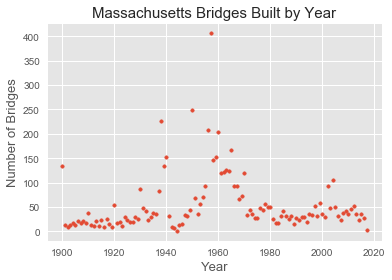

In [42]:
ma_year = dfma.Year_Built.value_counts().sort_index()

plt.scatter(ma_year.index, ma_year, s=12)
plt.yscale('linear')
plt.title('Massachusetts Bridges Built by Year', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Bridges', fontsize=13)
plt.show()

In [79]:
#dfma.to_csv('MAAdjusted.csv')

In [92]:
eda_helper(dfma)

,data_type,null_count,unique_count
Latitude,{float64},0,5486
Longitude,{float64},0,5485
Structure_Material,{float64},0,9
Structure_Type,{int64},0,20
Town,{str},0,339
Bridge_Owner,{int64},0,1
Bridge_Identification_Number__B,{str},0,5532
Year_Built,{int64},0,118
Year_Reconstructed,{int64},0,95
Structure_Length,{float64},0,1038


The following EDA was assigning all of the values to the equivalent number in the PA handbook so that the data would be consistent.

In [34]:
dfma = dfma[dfma.Structurally_Deficient != 'UNKNOWN']
#Remove all the unknowns from our dataset

In [41]:
dfma.Structurally_Deficient = dfma.Structurally_Deficient.replace({'YES':1, 'NO':0})

In [42]:
dfma.Structure_Category = dfma.Structure_Category.replace({'Bridge (NBI)': 1, 'Short Span Bridge':2, 'Culvert':3})

In [43]:
dfma = dfma[dfma.Structure_Material != '-']

In [44]:
dfma.Structure_Material = dfma.Structure_Material.replace({'Steel':1, 'Concrete':2, 'Prestressed concrete':3, 'Steel continuous':4, 
         'Masonry':5, 'Concrete continuous':6, 'Prestressed concrete continuous':7, 'Wood or Timber':8,
                     'Aluminum, Wrought Iron, or Cast Iron':9,'Other':0})
dfma.Structure_Material = dfma.Structure_Material.astype(float)

In [45]:
dfma.Structure_Type = dfma.Structure_Type.replace({'Stringer/Multi-beam or Girder':2, 'Culvert (includes frame culverts)':19, 
                                                   'Slab':1, 'Arch - Deck':11, 'Tee Beam':4, 
                                                   'Box Beam or Girders - Multiple':5, 
                                                   'Box Beam or Girders - Single or Spread':6, 'Frame (except frame culverts)':7,
                                                    'Girder and Floorbeam System':3,'Other':0, '-':0,
                                                  'Truss - Thru':10,'Segmental Box Girder':21,'Movable - Bascule':16,
                                                   'Arch - Thru':12,'Truss - Deck':9,'Mixed types':20,
                                                  'Movable - Swing':17,'Stayed Girder':14,'Movable - Lift':15,
                                                   'Suspension':13,'Channel Beam':22,})

In [65]:
dfma['Bridge_Owner'] = [1 if x == 'DOT' else 0 for x in dfma.Bridge_Owner]

In [66]:
Xma = dfma.drop(['Structurally_Deficient', 'Town','Bridge_Identification_Number__B'], axis = 1)
yma = dfma.Structurally_Deficient
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(Xma,yma)

print rfgs.best_params_
print rfgs.best_score_
#print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 5, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': None}
0.808981645328
[[5085  261]
 [  12   72]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97      5346
        1.0       0.22      0.86      0.35        84

avg / total       0.99      0.95      0.96      5430

0.949723756906
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Feature ranking:
1. feature Latitude (0.212305)
2. feature Longitude (0.205816)
3. feature Structure_Material (0.202536)
4. feature Structure_Type (0.188531)
5. feature Bridge_Owner (0.061426)
6. feature Year_Built (0.058293)
7. feature Year_Reconstructed (0.050578)
8. feature Structure_Length (0.020515)
9. feature Structure_Category (0.000000)


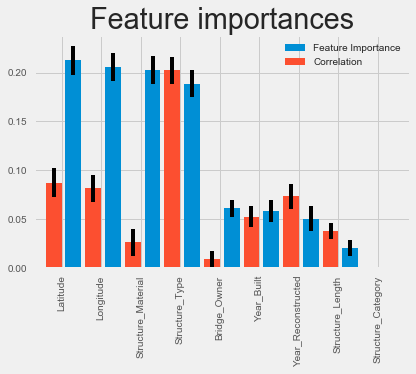

In [67]:
feature_importance = feature_importance_eda(Xma, yma)

In [68]:
Xma = dfma.drop(['Structurally_Deficient', 'Town','Bridge_Identification_Number__B'], axis = 1)
yma = dfma.Structurally_Deficient
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1, cv=10)
rfgs.fit(Xma,yma)

print rfgs.best_params_
print rfgs.best_score_
#print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 5, 'n_estimators': 25, 'criterion': 'gini', 'max_depth': 5, 'class_weight': None}
0.90708604483
[[5344    2]
 [  72   12]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      5346
        1.0       0.86      0.14      0.24        84

avg / total       0.98      0.99      0.98      5430

0.986372007366
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [69]:
from sklearn.model_selection import cross_val_predict
proba = cross_val_predict(rfgs, Xma, yma, cv=3, method='predict_proba')
proba

array([[ 0.97072315,  0.02927685],
       [ 0.92072861,  0.07927139],
       [ 0.92072861,  0.07927139],
       ..., 
       [ 0.98126728,  0.01873272],
       [ 0.9775037 ,  0.0224963 ],
       [ 0.97665832,  0.02334168]])

In [43]:
dfpa = dfpa_[['X','Y','BRIDGE_ID'
               , 'DESIGNMAIN', 'LENGTH', 'MATERIALMAIN', 
               'NBI_RATING', 'STATE_LOCAL','YEARBUILT', 'YEARRECON']] 

In [71]:
eda_helper(dfpa)

,data_type,null_count,unique_count
X,{float64},0,22384
Y,{float64},0,22298
BRIDGE_ID,"{int, str}",0,22410
DEPT_MAIN_MATERIAL_TYPE,{float64},0,9
DESIGNMAIN,{float64},0,17
LENGTH,{float64},0,972
MATERIALMAIN,{float64},0,10
NBI_RATING,{float64},0,2
STATE_LOCAL,{int64},0,2
STRRATING,{float64},0,9


In [44]:
Xpa = dfpa.drop(['NBI_RATING','BRIDGE_ID'], axis = 1)
ypa = dfpa.NBI_RATING

Feature ranking:
1. feature X (0.209342)
2. feature Y (0.206805)
3. feature DESIGNMAIN (0.194930)
4. feature LENGTH (0.172027)
5. feature MATERIALMAIN (0.081803)
6. feature STATE_LOCAL (0.061899)
7. feature YEARBUILT (0.053437)
8. feature YEARRECON (0.019758)


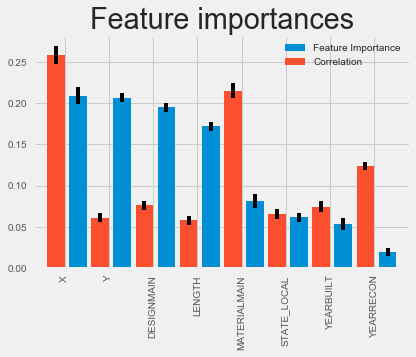

In [52]:
feature_importance = feature_importance_eda(Xpa, ypa)

In [74]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(Xpa,ypa)

print rfgs.best_params_
print rfgs.best_score_
#print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 2, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': None}
0.905882651679
[[5080  266]
 [  13   71]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97      5346
        1.0       0.21      0.85      0.34        84

avg / total       0.99      0.95      0.96      5430

0.94861878453
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [75]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1, cv=10)
rfgs.fit(Xpa,ypa)

print rfgs.best_params_
print rfgs.best_score_
#print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5, 'class_weight': None}
0.859928603302
[[5342    4]
 [  69   15]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      5346
        1.0       0.79      0.18      0.29        84

avg / total       0.98      0.99      0.98      5430

0.986556169429
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
